In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 1. 简单线性回归

### 1.1 一元线性回归

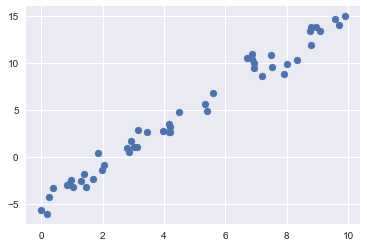

In [2]:
# 一元回归
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)

[2.02720881]
-4.998577085553202


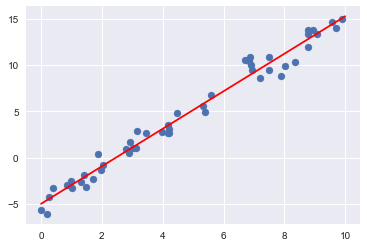

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit, c='r')

print(model.coef_)
print(model.intercept_)

### 1.2 多元线性回归

In [23]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)    # 100*3
# print(X)
Y = 0.5 + np.dot(X, [1.5, -2., 1.])    # y的shape: dot(100*3, 3*1) =100*1
# print(y)

model = LinearRegression()
model.fit(X, Y)
print(model.intercept_)
print(model.coef_)

# 预测
print(model.predict([[1,2,3]]))

0.5000000000000127
[ 1.5 -2.   1. ]
[1 2 3]
[[1 2 3]]
[1.]


## 2. 基函数回归

### 2.1 多项式基函数

In [24]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2,3,4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

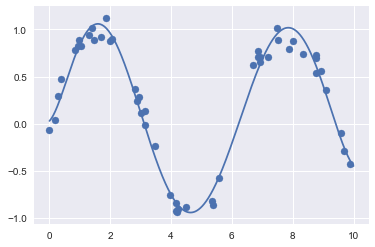

In [27]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),    # 转成7次多项式
                          LinearRegression())

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

### 2.2 高斯基函数

    - sklearn没有内置高斯基函数，可以写一个转换器来创建高斯基函数

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """一维输入均匀分布的高斯特征"""
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # 在数据区间中创建N个高斯分布中心
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

(0, 10)

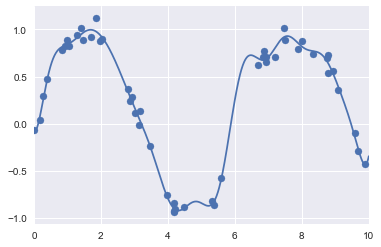

In [46]:
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)

## 3. 正则化

    - 虽然在线性回归模型中引入基函数会让模型变得更加灵活， 但是也很容易造成过拟合
        - 如果选择了太多高斯基函数， 那么最终的拟合结果看起来可能并不好
        - 如果对较大的模型参数进行惩罚（penalize)，从而抑制模型剧烈波动。 这个惩罚机制被称为正则化（regularization） 

(-1.5, 1.5)

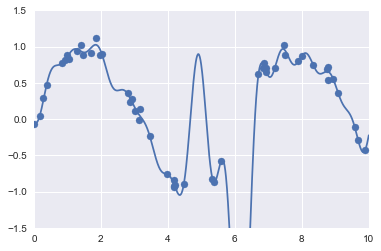

In [45]:

model = make_pipeline(GaussianFeatures(30), LinearRegression())
model.fit(x[:, np.newaxis], y)
plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

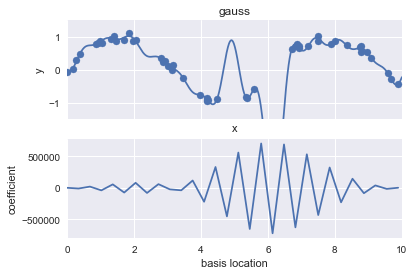

In [41]:
# 将高斯基函数的系数画出来（可以看到过拟合的原因）
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
        ax[1].plot(model.steps[0][1].centers_,
                  model.steps[1][1].coef_)
        ax[1].set(xlabel='basis location',
                 ylabel='coefficient',
                 xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model, 'gauss')   

### 3.1 岭回归（L2范数正则化）

    - 正则化最常见的形式，有时也称为吉洪诺夫正则化
        - 其处理方法是对模型系数平方和（L2 范数）进行惩罚
        - α 是一个自由参数， 用来控制惩罚的力度
        - 这种带惩罚项的模型内置在Scikit-Learn 的Ridge评估器中
    - 参数 α 是控制最终模型复杂度的关键。 
        - 如果 α → 0， 那么模型就恢复到标准线性回归结果
        - 如果 α →∞， 那么所有模型响应都会被压制。 
    - 岭回归的一个重要优点是，它可以非常高效地计算——因此相比原始的线性回归模型，几乎没有消耗更多的计算资源

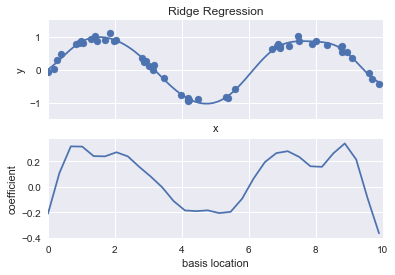

In [50]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

### 3.2 Lasso正则化（L1范数）

    - Lasso 正则化倾向于构建稀疏模型； 也就是说， 它更喜欢将模型系数设置为 0
    - 通过 Lasso 回归惩罚，大多数基函数的系数都变成了0， 所以模型变成了原来基函数的一小部分

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


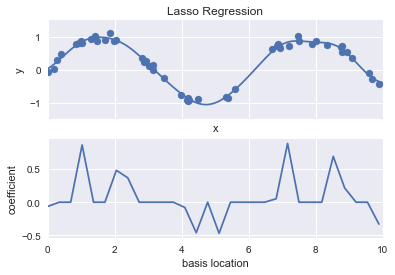

In [51]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

# 4. 案例：预测自行车流量（数据无法获取）